In [2]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

# Standard Trap-Diffusion Model

## Single Oppucation, Single Isotope Model

\begin{aligned}
&\begin{aligned}
\frac{d}{d t}\left(\begin{array}{c}
c_s \\
c_{t, 1} \\
c_{t, 2}
\end{array}\right) & =\left(\begin{array}{l}
1 / c^S \\
1 / c_1^T \\
1 / c_2^T
\end{array}\right) \circ \\
& \left\{\left(\begin{array}{ccc}
-\left(a_{T_1 S} c_1^T \sigma+a_{T_2 S} c_2^T \sigma\right) c^S & a_{S T_1} c_1^T & a_{S T_2} c_2^T \\
a_{T_1 S} c^S c_1^T \sigma & -a_{S T_1} c_1^T & 0 \\
a_{T_2 S} c^S c_2^T \sigma & 0 & -a_{S T_2} c_2^T
\end{array}\right)\left(\begin{array}{c}
c_s \\
c_{t, 1} \\
c_{t, 2}
\end{array}\right)\right.
\end{aligned}\\
&\left.+\left[\left(\begin{array}{c}
c_s \\
c_{t, 1} \\
c_{t, 2}
\end{array}\right) \circ\left(\begin{array}{ccc}
0 & \frac{a_{T_1 s} s^S c_1^T \sigma}{c_{t, 1}^{M a x}} & \frac{a_{T_2 s} s^S c_2^T \sigma}{c_{t, 2}^{M a x}} \\
-\frac{a_{T_1 s} c^s c_1^T \sigma}{c_{t, 1}^{M a x}} & 0 & 0 \\
-\frac{a_{T_2 s} c^T c_2^T \sigma}{c_{t, 2}^{M a x}} & 0 & 0
\end{array}\right)\left(\begin{array}{c}
c_s \\
c_{t, 1} \\
c_{t, 2}
\end{array}\right)\right]\right\}
\end{aligned}

$$
\begin{equation}
\frac{d}{d t} \vec{c}_{s, t}=\left(\frac{1}{\vec{c}^{ S / T}}\right) \circ\left[\underline{\underline{\mathbf{A}}} \vec{c}_{s, t}+\vec{c}_{s, t} \circ \underline{\underline{\mathbf{B}}} \vec{c}_{S, t}\right] .
\end{equation}
$$

$$
\begin{equation}
\underline{\underline{\mathbf{A}}}=\underline{\underline{\tilde{A}}} \underline{\underline{\mathbf{C}}}=\left(\begin{array}{ccc}
-\left(a_{T_1 S} c_1^T \sigma+a_{T_2 S} c_2^T \sigma\right) & a_{S T_1} & a_{S T_2} \\
a_{T_1 S} c_1^T \sigma & -a_{S T_1} & 0 \\
a_{T_2} s c_2^T \sigma & 0 & -a_{S T_2}
\end{array}\right)\left(\begin{array}{ccc}
c^S & 0 & 0 \\
0 & c_1^T & 0 \\
0 & 0 & c_2^T
\end{array}\right)
\end{equation}
$$

In [105]:
def random_setup(seed = None):
    np.random.seed(seed)
    # concentraion of trap sites and solute sites.
    # c_S_T = [c_S, c_T_1, c_T_2]
    c_S_T = np.random.random(3)
    c_S_T = c_S_T / np.sum(c_S_T)
    c_S, c_T_1, c_T_2 = c_S_T
    # site concentration matrix
    C = np.diag(c_S_T)

    # max trap conentration, has to be greater than current concentration
    c_Max_1 = np.random.random()/2
    c_Max_2 = np.random.random()/2

    # capture cross-section of trap-site
    sigma = 1

    # base transition rates
    a = np.random.random((3,3))

    # transition rate matrix
    A_tilde = np.array([
        [-(a[1,0]* c_T_1*sigma + a[2,0]*c_T_2*sigma), a[0,1], a[0,2]],
        [a[1,0]*c_T_1*sigma, -a[0,1], 0],
        [a[2,0]*c_T_2*sigma, 0, -a[0,2]]
    ])

    A = A_tilde @ C

    B = np.array([
        [0, (a[1,0]*c_S*c_T_1*sigma)/ c_Max_1, (a[2,0]*c_S*c_T_2*sigma)/ c_Max_2],
        [0, 0, 0],
        [0, 0, 0]
    ])
    # fill in anty-symmetric part
    B[:, 0] = -B[0,:]

    # random start concetrations
    c = np.random.random(3)
    c[1] *= c_Max_1
    c[2] *= c_Max_2
    c[0] = 1 - c[1] - c[2]

    return c, c_S_T,  A, B, c_Max_1, c_Max_2

def hadamard(A,B):
    if len(A.shape) == 1:
        return (A*B.T).T
    else:
        return A*B
def rhs(c,t,c_S_T,A,B):
    return hadamard(1/c_S_T, A@c + hadamard(c,B@c))
def jacobi(c,t,c_S_T,A,B):
    return hadamard(1/c_S_T, A + hadamard(np.ones(3), B@c) + hadamard(c,B))

- $c_{t,i}$ : concentration of hydrogen trapped in trap of type i
- $c_j^T$ : concentration of traps of type j
- $c_{s}$ : concentration of solute hydrogen in non-trap (solute) sites
- $c^S$ : concentration of solute sites
- $a_{i\leftarrow j}$ : transition rate from j to i, typically in matrix notation in row i and columnn j
- $c_{t,i}^{Max} $ : the upper limit (maximum) of the hydrogen concentration which can be trapped in a trap of type i (capacity limit of trap)
- $\sigma$ : capture cross-section of a trap-site

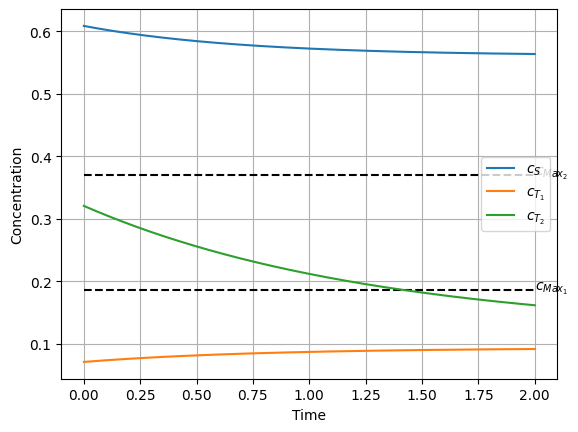

In [113]:
def plot_random(seed = None):
    c, c_S_T, A, B, c_Max_1, c_Max_2 = random_setup()
    ts = np.linspace(0,2,1000)
    sol = odeint(func = rhs, y0 = c,t = ts,args=(c_S_T, A,B),Dfun = jacobi)
    plt.plot(ts,sol[:,0], label = "$c_S$")
    plt.plot(ts,sol[:,1], label = "$c_{T_1}$")
    plt.hlines([c_Max_1], 0, ts[-1], linestyles = "dashed", color = "black")
    plt.text(ts[-1], c_Max_1, "$c_{Max_1}$")
    plt.plot(ts, sol[:,2], label = "$c_{T_2}$")
    plt.hlines([c_Max_2], 0, ts[-1], linestyles = "dashed", color = "black")
    plt.text(ts[-1], c_Max_2, "$c_{Max_2}$")
    plt.legend()
    plt.ylabel("Concentration")
    plt.xlabel("Time")
    plt.grid()
plot_random()